# Pixie

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StructField, StringType, IntegerType,TimestampType

spark = SparkSession \
    .builder \
    .appName("Spark_Processor") \
    .master("local[*]") \
    .getOrCreate()

sc = spark.sparkContext

schema = StructType([ \
        StructField("DEVICE_CODE", IntegerType(), True), 
        StructField("SYSTEM_ID",IntegerType(),True), \
        StructField("ORIGINE_CAR_KEY",IntegerType(),True), \
        StructField("FINAL_CAR_KEY", IntegerType(),True), \
        StructField("CHECK_STATUS_KEY", IntegerType(), True), \
        StructField("COMPANY_ID", StringType(), True), \
        StructField("PASS_DAY_TIME", TimestampType(), True)
    ])

22/02/08 11:26:48 WARN Utils: Your hostname, jupyter resolves to a loopback address: 127.0.1.1; using 172.16.199.17 instead (on interface eth0)
22/02/08 11:26:48 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/02/08 11:26:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/02/08 11:26:51 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


---- [('spark.sql.warehouse.dir', 'file:/home/user1/jupyter/MassiveDataAnalytics/project/spark-warehouse'), ('spark.executor.id', 'driver'), ('spark.app.name', 'Spark_Processor'), ('spark.driver.host', '172.16.199.17'), ('spark.executor.memory', '64g'), ('spark.app.startTime', '1644319609594'), ('spark.driver.memory', '64g'), ('spark.rdd.compress', 'True'), ('spark.serializer.objectStreamReset', '100'), ('spark.master', 'local[*]'), ('spark.submit.pyFiles', ''), ('spark.driver.port', '46397'), ('spark.submit.deployMode', 'client'), ('spark.app.id', 'local-1644319611673'), ('spark.ui.showConsoleProgress', 'true')]


In [3]:
df = spark.read.csv('Traffic.csv',header=True,schema=schema)
df.show(1)

+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|DEVICE_CODE|SYSTEM_ID|ORIGINE_CAR_KEY|FINAL_CAR_KEY|CHECK_STATUS_KEY|COMPANY_ID|      PASS_DAY_TIME|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|     200501|       81|       10477885|     10477885|               5|       161|2021-06-01 03:54:39|
|        155|       81|       87625017|     87625017|               5|       161|2021-06-01 04:14:21|
|     631757|       81|        8652928|      8652928|               5|       161|2021-06-01 03:58:57|
|     631757|       81|        8548123|      8548123|               5|       161|2021-06-01 04:01:38|
|     631757|       81|       24715264|     24715264|               5|       161|2021-06-01 03:56:57|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+
only showing top 5 rows



In [ ]:
from pyspark.sql.functions import dayofyear
df = df.withColumn('day', dayofyear(df.PASS_DAY_TIME))
df = df.filter(df.day != 159)
df.show(1)

# CLEAN ?

In [ ]:
car_counts = df.groupBy('FINAL_CAR_KEY').count()
traffic_cars = car_counts.filter(car_counts['count'] < 1000).sort('count', ascending=False).select('FINAL_CAR_KEY').take(1000)
traffic_cars = [x.FINAL_CAR_KEY for x in traffic_cars]
top_cars_df = df.filter(df.FINAL_CAR_KEY.isin(traffic_cars))
print(top_cars_df.count())
top_cars_df.show(5)

In [7]:
camera_car_df = top_cars_df.groupBy('DEVICE_CODE', 'FINAL_CAR_KEY').count()
camera_car_df.show(5)

+-----------+-------------+-----+
|DEVICE_CODE|FINAL_CAR_KEY|count|
+-----------+-------------+-----+
|     631367|      8642668|    6|
|     631357|     13565906|   16|
|     900249|     11054045|   14|
|     900237|     17890990|   21|
|     631829|     11054045|    6|
+-----------+-------------+-----+
only showing top 5 rows



In [8]:
from pyspark.ml.feature import StringIndexer

camera_car_indexed_df = StringIndexer(inputCol='FINAL_CAR_KEY', outputCol='CAR_INDEX').fit(camera_car_df).transform(camera_car_df)
camera_car_indexed_df = StringIndexer(inputCol='DEVICE_CODE', outputCol='CAMERA_INDEX').fit(camera_car_indexed_df).transform(camera_car_indexed_df)

camera_car_indexed_df.show(5)

+-----------+-------------+-----+---------+------------+
|DEVICE_CODE|FINAL_CAR_KEY|count|CAR_INDEX|CAMERA_INDEX|
+-----------+-------------+-----+---------+------------+
|     631367|      8642668|    6|     21.0|        38.0|
|     631357|     13565906|   16|      7.0|        67.0|
|     900249|     11054045|   14|     43.0|        21.0|
|     900237|     17890990|   21|     23.0|        10.0|
|     631829|     11054045|    6|     43.0|        32.0|
+-----------+-------------+-----+---------+------------+
only showing top 5 rows



In [13]:
cars_edges = camera_car_indexed_df.rdd.map(lambda x: (int(x.CAR_INDEX), int(x.CAMERA_INDEX))).groupByKey().mapValues(list).sortByKey()
camera_edges = camera_car_indexed_df.rdd.map(lambda x: (int(x.CAMERA_INDEX), int(x.CAR_INDEX))).groupByKey().mapValues(list).sortByKey()
CAR_COUNT = cars_edges.count()
CAMERA_COUNT = camera_edges.count()
# cars_edges.take(2)
# camera_edges.take(2)

(1,
 [36,
  25,
  43,
  5,
  34,
  35,
  18,
  0,
  1,
  7,
  23,
  53,
  57,
  30,
  42,
  14,
  44,
  10,
  6,
  55,
  19,
  31,
  46,
  37,
  8,
  41,
  17,
  50,
  47,
  60,
  4,
  33,
  94,
  3,
  12,
  29,
  40,
  71,
  11,
  21,
  24,
  28,
  54,
  39,
  16,
  26,
  65,
  22,
  59])

In [18]:
import os
import random
os.environ['PYTHONHASHSEED'] = '0'

camera_scores = [0]*CAMERA_COUNT

related_camera = query_camera = 400
STEPS = 10000
alpha = 0.2
for i in range(STEPS):
    if i%100 == 0:
        print('i is: ',i)

    related_car = camera_edges.lookup(query_camera)[0]
    r = random.randint(0, len(related_car)-1)
    related_car = related_car[r]

    related_camera = cars_edges.lookup(related_car)[0]
    r = random.randint(0, len(related_camera)-1)
    related_camera = related_camera[r]
    camera_scores[related_camera] += 1

    r = random.random()
    if r < alpha:
        related_camera = query_camera


print(camera_scores)


i is:  0


Exception in thread "serve RDD 745 with partitions 0" java.net.SocketTimeoutException: Accept timed out
	at java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:409)
	at java.net.ServerSocket.implAccept(ServerSocket.java:560)
	at java.net.ServerSocket.accept(ServerSocket.java:528)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:64)


i is:  100
i is:  200
i is:  300
i is:  400
i is:  500
i is:  600
i is:  700
i is:  800
i is:  900
[6, 12, 15, 8, 8, 11, 9, 11, 6, 7, 10, 10, 7, 13, 9, 6, 8, 5, 10, 8, 10, 11, 3, 5, 7, 2, 7, 8, 2, 2, 10, 4, 11, 1, 6, 8, 8, 11, 9, 5, 8, 2, 12, 3, 7, 8, 6, 8, 7, 5, 10, 8, 7, 4, 4, 2, 1, 1, 3, 6, 4, 3, 10, 3, 2, 0, 2, 9, 5, 5, 2, 4, 3, 4, 2, 3, 2, 10, 6, 2, 6, 0, 1, 2, 3, 0, 5, 5, 8, 0, 6, 0, 5, 6, 6, 5, 3, 1, 7, 4, 11, 5, 6, 4, 2, 2, 1, 3, 4, 2, 1, 4, 4, 6, 2, 8, 6, 1, 5, 5, 4, 1, 2, 3, 1, 2, 1, 4, 5, 7, 0, 1, 5, 6, 3, 0, 0, 3, 2, 1, 5, 3, 4, 5, 6, 5, 1, 1, 1, 7, 2, 1, 3, 4, 1, 0, 2, 2, 3, 1, 2, 0, 2, 0, 4, 6, 5, 4, 4, 2, 4, 4, 2, 0, 0, 4, 1, 0, 0, 3, 2, 3, 2, 2, 0, 5, 5, 4, 2, 1, 0, 3, 2, 2, 5, 3, 7, 0, 2, 0, 0, 6, 0, 2, 2, 2, 0, 3, 0, 2, 3, 0, 0, 6, 1, 0, 0, 3, 2, 4, 0, 0, 2, 1, 0, 1, 0, 1, 0, 0, 2, 0, 2, 2, 5, 1, 5, 0, 2, 2, 0, 1, 2, 2, 0, 2, 2, 0, 0, 0, 0, 1, 0, 0, 1, 2, 0, 0, 0, 0, 1, 0, 0, 2, 1, 1, 1, 2, 1, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 1, 0, 0, 0, 2, 2, 0, 

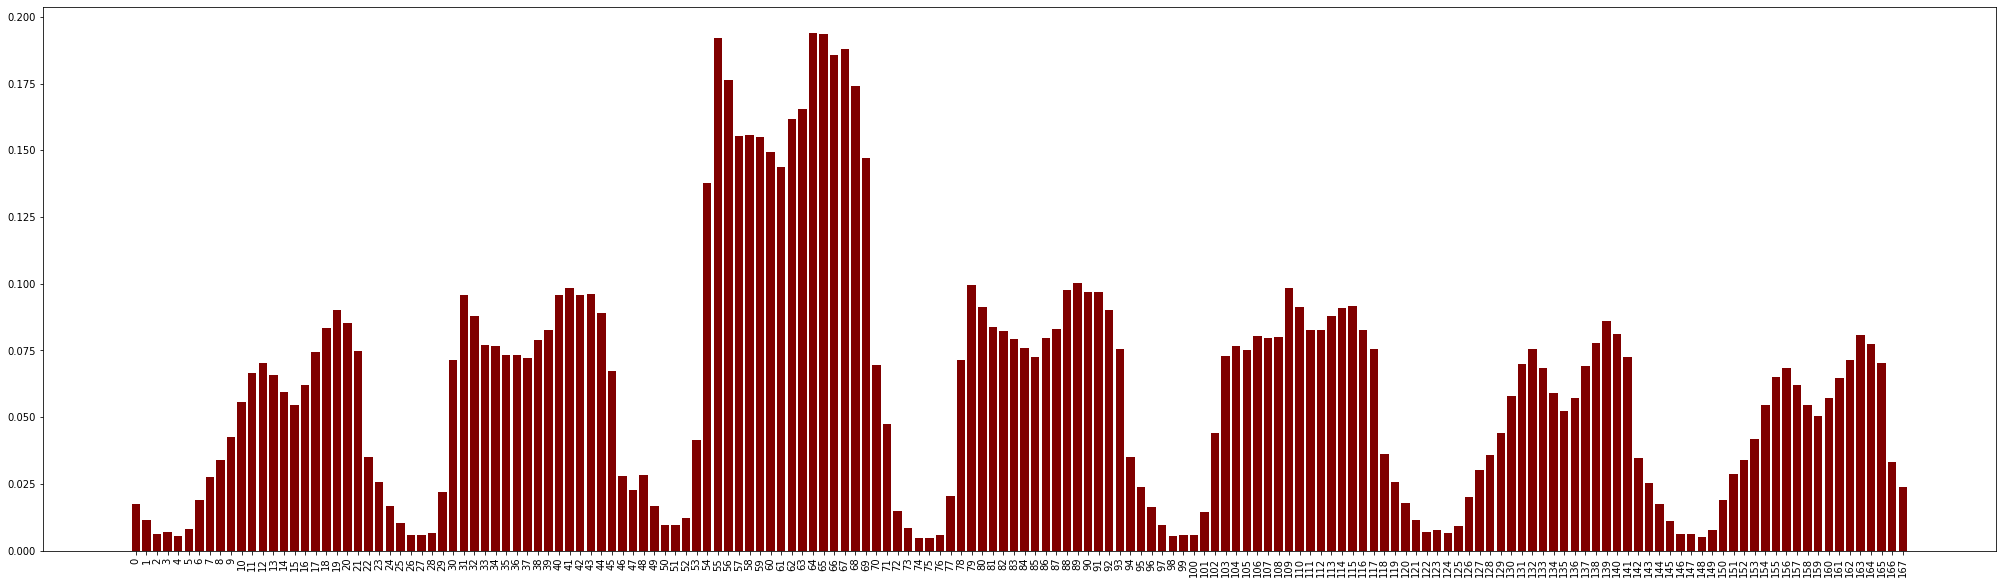

In [24]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize = (40, 10))
labels = list(map(lambda x: str(x), range(len(camera_scores))))
plt.bar(labels, camera_scores, color='red', width = 0.7)
plt.xticks(rotation='vertical',fontsize=10)
plt.show()